# <center> Pennsylvania Incomes and GDP Compared with Top Venues </center>
This model will look at the most recent economic data for Pennsylvania on county basis.\
Will look to provide correlation in the top venues and common venues for high GDP and low GDP areas.\
Will assist PA economic board to metrics to improve.

In [1]:
# Install neccessary packages
!pip install geopy
!pip install beautifulsoup4
!pip install folium==0.5.0

# Import numerical and dataframe libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import MinMaxScaler

# Import file handling libraries
import json
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 

# Import graphical libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from  matplotlib import pyplot
import seaborn

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import linear_model

print('Imports complete!')

Imports complete!


## Part 1 - Import and Clean Data
Load data from Wikipedia table, .CSV file, and Foursquare

### 1.A - Import Data!

In [2]:
df_economic = pd.read_html('https://en.wikipedia.org/wiki/List_of_Pennsylvania_counties_by_per_capita_income')

In [3]:
df_location = pd.read_csv('County_Latitude___Longitude_Points_For_Each_County_Static.csv')

### 1.B - Lets look at the economic data first!
Note that read_html will read in the webpage as a list of dataframes!\
Dateframe [0] is the heder paragraph while the 2nd is the actual table!

In [4]:
# Use table, which is 2nd element (first[0] is header info)
df_economic = df_economic[1]

In [5]:
df_economic.head()

Rank      County Per capitaincome Medianhouseholdincome Medianfamilyincome  \
0   1.0     Chester          $41,251               $84,741            $94,592   
1   2.0  Montgomery          $40,076               $76,380            $94,592   
2   3.0       Bucks          $35,687               $74,828            $90,274   
3   4.0    Delaware          $32,067               $61,876            $77,879   
4   5.0  Cumberland          $30,119               $60,219            $75,000   

   Population  Number ofhouseholds  Unnamed: 7  
0      799874             307750.0         NaN  
1      799874                  NaN         NaN  
2      625249             234849.0         NaN  
3      558979             208700.0         NaN  
4      235406              93943.0         NaN

In [6]:
# Delete useless columns
df_economic.drop(columns=['Rank','Number ofhouseholds','Unnamed: 7'],inplace=True)

In [7]:
# Rename columns
df_economic.columns = ['County', 'Per Capita Income', 'Median Household Income','Median Family Income', 'Population']

In [8]:
df_economic['County'].sort_values().unique()

array(['Adams', 'Allegheny', 'Armstrong', 'Beaver', 'Bedford', 'Berks',
       'Blair', 'Bradford', 'Bucks', 'Butler', 'Cambria', 'Cameron',
       'Carbon', 'Centre', 'Chester', 'Clarion', 'Clearfield', 'Clinton',
       'Columbia', 'Crawford', 'Cumberland', 'Dauphin', 'Delaware', 'Elk',
       'Erie', 'Fayette', 'Forest', 'Franklin', 'Fulton', 'Greene',
       'Huntingdon', 'Indiana', 'Jefferson', 'Juniata', 'Lackawanna',
       'Lancaster', 'Lawrence', 'Lebanon', 'Lehigh', 'Luzerne',
       'Lycoming', 'McKean', 'Mercer', 'Mifflin', 'Monroe', 'Montgomery',
       'Montour', 'Northampton', 'Northumberland', 'Pennsylvania',
       'Perry', 'Philadelphia', 'Pike', 'Potter', 'Schuylkill', 'Snyder',
       'Somerset', 'Sullivan', 'Susquehanna', 'Tioga', 'Union',
       'United States', 'Venango', 'Warren', 'Washington', 'Wayne',
       'Westmoreland', 'Wyoming', 'York'], dtype=object)

In [9]:
# This dataset included PA and US totals! Delete these rows!
df_economic.drop(df_economic[(df_economic['County'] == 'Pennsylvania')|(df_economic['County'] == 'United States')].index,inplace=True)
df_economic.reset_index(inplace=True,drop=True)

In [10]:
df_economic.shape

(67, 5)

### 1.C - County Centroid locations!

In [11]:
df_location.dtypes

County Name                            object
County Code Number                      int64
County Code text                        int64
Longitude                             float64
Latitude                              float64
Georeferenced Latitude & Longitude     object
dtype: object

In [12]:
df_location['County Name'].unique()

array(['Adams', 'Allegheny', 'Armstrong', 'Beaver', 'Bedford', 'Berks',
       'Blair', 'Bradford', 'Bucks', 'Butler', 'Cambria', 'Cameron',
       'Carbon', 'Centre', 'Chester', 'Clarion', 'Pennsylvania',
       'Clearfield', 'Clinton', 'Columbia', 'Crawford', 'Cumberland',
       'Dauphin', 'Delaware', 'Elk', 'Erie', 'Fayette', 'Forest',
       'Franklin', 'Fulton', 'Greene', 'Huntingdon', 'Indiana',
       'Jefferson', 'Juniata', 'Lackawanna', 'Lancaster', 'Lawrence',
       'Lebanon', 'Lehigh', 'Luzerne', 'Lycoming', 'McKean', 'Mercer',
       'Mifflin', 'Monroe', 'Montgomery', 'Montour', 'Northampton',
       'Northumberland', 'Perry', 'Philadelphia', 'Pike', 'Potter',
       'Schuylkill', 'Snyder', 'Somerset', 'Sullivan', 'Susquehanna',
       'Tioga', 'Union', 'Venango', 'Warren', 'Washington', 'Wayne',
       'Westmoreland', 'Wyoming', 'York'], dtype=object)

In [13]:
df_location.shape

(68, 6)

In [14]:
df_location.head()

County Name  County Code Number  County Code text  Longitude   Latitude  \
0       Adams                   1                 1 -77.222243  39.872096   
1   Allegheny                   2                 2 -79.986198  40.467355   
2   Armstrong                   3                 3 -79.473169  40.815095   
3      Beaver                   4                 4 -80.351074  40.683492   
4     Bedford                   5                 5 -78.491165  40.007375   

  Georeferenced Latitude & Longitude  
0   POINT (-77.22224271 39.87209565)  
1   POINT (-79.98619843 40.46735543)  
2   POINT (-79.47316899 40.81509526)  
3   POINT (-80.35107356 40.68349245)  
4   POINT (-78.49116474 40.00737536)

In [15]:
df_location.drop(columns=['County Code Number','County Code text','Georeferenced Latitude & Longitude'],inplace=True)

In [16]:
df_location['County Name'].sort_values().unique()

array(['Adams', 'Allegheny', 'Armstrong', 'Beaver', 'Bedford', 'Berks',
       'Blair', 'Bradford', 'Bucks', 'Butler', 'Cambria', 'Cameron',
       'Carbon', 'Centre', 'Chester', 'Clarion', 'Clearfield', 'Clinton',
       'Columbia', 'Crawford', 'Cumberland', 'Dauphin', 'Delaware', 'Elk',
       'Erie', 'Fayette', 'Forest', 'Franklin', 'Fulton', 'Greene',
       'Huntingdon', 'Indiana', 'Jefferson', 'Juniata', 'Lackawanna',
       'Lancaster', 'Lawrence', 'Lebanon', 'Lehigh', 'Luzerne',
       'Lycoming', 'McKean', 'Mercer', 'Mifflin', 'Monroe', 'Montgomery',
       'Montour', 'Northampton', 'Northumberland', 'Pennsylvania',
       'Perry', 'Philadelphia', 'Pike', 'Potter', 'Schuylkill', 'Snyder',
       'Somerset', 'Sullivan', 'Susquehanna', 'Tioga', 'Union', 'Venango',
       'Warren', 'Washington', 'Wayne', 'Westmoreland', 'Wyoming', 'York'],
      dtype=object)

In [17]:
# This dataset provided coordinates for PA, lets delete!
delete =df_location[df_location['County Name'] == 'Pennsylvania'].index
df_location.drop(delete,inplace=True)
df_location.reset_index(inplace=True,drop=True)

In [18]:
df_location.shape

(67, 3)

### 1.D - Merge datasets into single county set!

In [19]:
df_county = pd.merge(left=df_economic, right=df_location, left_on='County', right_on='County Name')

In [20]:
df_county.drop(columns=['County Name'],inplace=True)

In [21]:
# Remove dollar sign and comma
df_county[df_county.columns[1:4]] = df_county[df_county.columns[1:4]].replace({'\$':'','\,':''}, regex = True)
df_county[df_county.columns[1:]] = df_county[df_county.columns[1:]].apply(pd.to_numeric)

In [22]:
df_county.shape

(67, 7)

### 1.E - Use Foursquare to get county venues!!
Find top venue categories within 20 mile radius of county center./
Group venues by county and category with totals for venue type per county.

In [23]:
# Importing my foursquare credentials
CLIENT_ID = 'B115BXHGKH1S2H5OR42QKHDU020WMW5U4SVA2LF5ZKLTXORG' # your Foursquare ID
CLIENT_SECRET = '14X4KNDGZVJPA1NKAB5MXUIWPCEDNNP1OQY3ASN5HQKICVCZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B115BXHGKH1S2H5OR42QKHDU020WMW5U4SVA2LF5ZKLTXORG
CLIENT_SECRET:14X4KNDGZVJPA1NKAB5MXUIWPCEDNNP1OQY3ASN5HQKICVCZ


In [24]:
def getNearbyVenues(county, latitude, longitude, radius=32000):
    
    venues_list=[]
    for name, lat, lng in zip(county, latitude, longitude):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['County', 
                  'County Latitude', 
                  'County Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
pa_venues = getNearbyVenues(county=df_location['County Name'],
                                latitude = df_location['Latitude'],
                                longitude=df_county['Longitude'])

Adams
Allegheny
Armstrong
Beaver
Bedford
Berks
Blair
Bradford
Bucks
Butler
Cambria
Cameron
Carbon
Centre
Chester
Clarion
Clearfield
Clinton
Columbia
Crawford
Cumberland
Dauphin
Delaware
Elk
Erie
Fayette
Forest
Franklin
Fulton
Greene
Huntingdon
Indiana
Jefferson
Juniata
Lackawanna
Lancaster
Lawrence
Lebanon
Lehigh
Luzerne
Lycoming
McKean
Mercer
Mifflin
Monroe
Montgomery
Montour
Northampton
Northumberland
Perry
Philadelphia
Pike
Potter
Schuylkill
Snyder
Somerset
Sullivan
Susquehanna
Tioga
Union
Venango
Warren
Washington
Wayne
Westmoreland
Wyoming
York


In [26]:
pa_venues.head()

County  County Latitude  County Longitude             Venue  Venue Latitude  \
0  Adams        39.872096        -75.756265    Talula's Table       39.846645   
1  Adams        39.872096        -75.756265     Sovana Bistro       39.874008   
2  Adams        39.872096        -75.756265           Philter       39.846679   
3  Adams        39.872096        -75.756265  The Conservatory       39.872931   
4  Adams        39.872096        -75.756265  Longwood Gardens       39.871343   

   Venue Longitude           Venue Category  
0       -75.711772             Gourmet Shop  
1       -75.717426  New American Restaurant  
2       -75.712175              Coffee Shop  
3       -75.678081                   Garden  
4       -75.674601         Botanical Garden

In [27]:
pa_venues.shape

(5900, 7)

In [28]:
pa_venues.drop(columns=['County Latitude', 'County Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude'],inplace=True)

In [29]:
pa_venue_cat = pd.get_dummies(pa_venues[['Venue Category']],prefix="", prefix_sep="")

In [30]:
pa_venue_cat['County'] = pa_venues['County'].copy()

In [31]:
pa_venue_cat = pa_venue_cat.groupby(by='County',as_index=False).sum()

In [32]:
pa_venue_cat.head()

County  Accessories Store  Airport  Airport Terminal  \
0      Adams                  0        0                 0   
1  Allegheny                  0        0                 0   
2  Armstrong                  0        0                 0   
3     Beaver                  0        0                 0   
4    Bedford                  0        0                 0   

   American Restaurant  Antique Shop  Apres Ski Bar  Arcade  \
0                    4             0              0       0   
1                    6             0              0       0   
2                    6             0              0       0   
3                    4             0              1       0   
4                    8             1              0       0   

   Argentinian Restaurant  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0                       0           0                    0                 2   
1                       0           0                    0                 0   
2                       0           0                    0                 0   
3                       0           0                    0                 0   
4                       0           0                    0                 2   

   Athletics & Sports  Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                   0                      0          0           0       2   
1                   0                      0          2           0       3   
2                   0                      1          0           1       2   
3                   0                      1          0           0       2   
4                   0                      0          1           0       1   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  Beach  \
0     0    0               0                 0                 0      0   
1     0    2               0                 1                 0      0   
2     0    4               0                 0                 0      0   
3     0    3               0                 1                 0      0   
4     0    1               0                 0                 0      1   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  Bistro  \
0                0         0            1           1              0       0   
1                0         0            0           3              1       0   
2                0         0            0           0              0       1   
3                0         0            0           2              1       0   
4                0         0            1           0              0       1   

   Bookstore  Botanical Garden  Boutique  Bowling Alley  Bowling Green  \
0          0                 1         0              0              0   
1          3                 0         0              0              0   
2          2                 0         0              0              0   
3          3                 0         0              0              0   
4          0                 0         0              0              0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Buffet  Burger Joint  \
0                     0               0        5       0             1   
1                     0               3        7       0             1   
2                     0               1        3       0             2   
3                     0               2        6       0             2   
4                     0               0        3       0             1   

   Burrito Place  Butcher  Café  Cajun / Creole Restaurant  Campground  \
0              0        0     1                          0           0   
1              1        0     3                          1           0   
2              0        0     2                          0           1   
3              1        0     3                          1           0   
4              0        0     3                          0           1   

   Candy Store  Caribbean Resta

</br>

## Part 2 - Analysis
Use county venue categories to forecast which venues drive economic index higher and lower

### 2.A - Create economic index metric
The economic data is normalized using a minimum-maximum scaler.
Economic index is the average of per capita income, median hosuehold income, and median family income.

In [33]:
# Normalize income data
scaler = MinMaxScaler()

In [34]:
df_county[['Per Capita Income','Median Household Income','Median Family Income']] = scaler.fit_transform(df_county[['Per Capita Income','Median Household Income','Median Family Income']])

In [35]:
# Create average economic metric
df_county['Economic Index'] = df_county[['Per Capita Income','Median Household Income','Median Family Income']].mean(axis=1)

In [36]:
df_county.head()

County  Per Capita Income  Median Household Income  \
0     Chester           1.000000                 1.000000   
1  Montgomery           0.956362                 0.832596   
2       Bucks           0.793360                 0.801522   
3    Delaware           0.658917                 0.542196   
4  Cumberland           0.586571                 0.509020   

   Median Family Income  Population  Longitude   Latitude  Economic Index  
0              1.000000      799874 -75.756265  39.974871        1.000000  
1              1.000000      799874 -75.372520  40.209899        0.929653  
2              0.915070      625249 -75.112912  40.335011        0.836650  
3              0.671276      558979 -75.406277  39.916579        0.624130  
4              0.614649      235406 -77.268663  40.167598        0.570080

### 2.B - Linear Regression
Use multiple linear regression (MLR). </br>
Fit economic index vs. venue category and use coefficients as 

In [37]:
df_econ_index = pd.merge(left=df_county[['County','Economic Index']],right=pa_venue_cat,on='County',)

In [38]:
df_econ_index.head()

County  Economic Index  Accessories Store  Airport  Airport Terminal  \
0     Chester        1.000000                  0        0                 0   
1  Montgomery        0.929653                  0        0                 0   
2       Bucks        0.836650                  0        0                 0   
3    Delaware        0.624130                  0        0                 0   
4  Cumberland        0.570080                  0        0                 0   

   American Restaurant  Antique Shop  Apres Ski Bar  Arcade  \
0                    3             0              0       0   
1                   11             0              0       0   
2                    5             0              0       0   
3                    3             0              0       0   
4                    1             0              0       0   

   Argentinian Restaurant  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0                       0           0                    1                 2   
1                       0           0                    0                 1   
2                       0           0                    0                 1   
3                       0           0                    0                 0   
4                       0           2                    0                 0   

   Athletics & Sports  Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                   0                      0          0           0       5   
1                   0                      0          1           0       3   
2                   0                      0          2           0       2   
3                   0                      0          0           0       2   
4                   1                      0          1           0       1   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  Beach  \
0     0    2               0                 0                 0      0   
1     0    1               0                 0                 0      0   
2     0    0               0                 0                 0      0   
3     0    1               0                 1                 0      0   
4     0    2               0                 0                 0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  Bistro  \
0                0         0            1           1              0       0   
1                0         0            0           0              1       1   
2                0         0            0           0              0       0   
3                0         0            1           1              0       0   
4                0         0            0           0              0       0   

   Bookstore  Botanical Garden  Boutique  Bowling Alley  Bowling Green  \
0          0                 0         0              1              0   
1          2                 0         0              0              0   
2          2                 0         0              0              0   
3          0                 1         0              0              0   
4          0                 0         1              0              0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Buffet  Burger Joint  \
0                     0               0        5       2             0   
1                     0               1        5       0             1   
2                     0               0        7       0             2   
3                     0               0        9       0             1   
4                     1               2        5       0             0   

   Burrito Place  Butcher  Café  Cajun / Creole Restaurant  Campground  \
0              1        0     4                          0           0   
1              1        0     4                          0           0   
2              2        0     2                          0           0   
3              2        0     2                          0           0   
4    

In [39]:
df_econ_index.shape

(67, 266)

In [40]:
state_average = df_econ_index.mean()
state_median = df_econ_index.median()
ei_avg = state_average[0]
ei_median = state_median[0]
state_average.drop(index='Economic Index',inplace=True)
state_median.drop(index='Economic Index',inplace=True)

In [41]:
print(state_average.sort_values(ascending=False))

American Restaurant                5.850746
Pizza Place                        4.149254
Ice Cream Shop                     3.029851
Italian Restaurant                 2.970149
Bar                                2.865672
Brewery                            2.776119
Sandwich Place                     2.701493
Discount Store                     2.641791
Coffee Shop                        2.641791
Grocery Store                      2.492537
Gas Station                        2.014925
Park                               1.716418
Restaurant                         1.597015
Café                               1.582090
Bakery                             1.537313
Fast Food Restaurant               1.462687
Hotel                              1.447761
Mexican Restaurant                 1.388060
Diner                              1.343284
Convenience Store                  1.059701
Pub                                1.044776
Pharmacy                           0.955224
Farmers Market                  

In [42]:
print(state_median.sort_values(ascending=False))

American Restaurant                6.0
Pizza Place                        4.0
Ice Cream Shop                     3.0
Brewery                            3.0
Italian Restaurant                 3.0
Bar                                3.0
Sandwich Place                     2.0
Grocery Store                      2.0
Coffee Shop                        2.0
Café                               2.0
Farmers Market                     1.0
Gas Station                        1.0
Steakhouse                         1.0
State / Provincial Park            1.0
Park                               1.0
Burger Joint                       1.0
Mexican Restaurant                 1.0
Convenience Store                  1.0
Pub                                1.0
Chinese Restaurant                 1.0
Bakery                             1.0
Restaurant                         1.0
Gym                                1.0
Fast Food Restaurant               1.0
Pharmacy                           1.0
Donut Shop               

### Note - 
From the above, we see that venues where the median is > 0 and mean is > 0.55 can be considered common to all counties. </br>
Thus we will remove those venues before performing the linear regression.

In [43]:
# Remove venue categories that are common to all counties: median > 0 to average above 0.55
to_drop = state_average[(state_average > 0.55) | (state_median > 0)].index.to_list()

In [44]:
to_drop

['American Restaurant',
 'BBQ Joint',
 'Bakery',
 'Bar',
 'Breakfast Spot',
 'Brewery',
 'Burger Joint',
 'Café',
 'Chinese Restaurant',
 'Coffee Shop',
 'Convenience Store',
 'Diner',
 'Discount Store',
 'Donut Shop',
 'Farmers Market',
 'Fast Food Restaurant',
 'Gas Station',
 'Golf Course',
 'Grocery Store',
 'Gym',
 'Hotel',
 'Ice Cream Shop',
 'Italian Restaurant',
 'Mexican Restaurant',
 'New American Restaurant',
 'Park',
 'Pharmacy',
 'Pizza Place',
 'Pub',
 'Restaurant',
 'Sandwich Place',
 'Scenic Lookout',
 'State / Provincial Park',
 'Steakhouse',
 'Supermarket',
 'Trail']

In [45]:
df_econ_index.drop(columns=to_drop,inplace=True)

In [46]:
df_econ_index.shape

(67, 230)

In [47]:
df_econ_index.head()

County  Economic Index  Accessories Store  Airport  Airport Terminal  \
0     Chester        1.000000                  0        0                 0   
1  Montgomery        0.929653                  0        0                 0   
2       Bucks        0.836650                  0        0                 0   
3    Delaware        0.624130                  0        0                 0   
4  Cumberland        0.570080                  0        0                 0   

   Antique Shop  Apres Ski Bar  Arcade  Argentinian Restaurant  Art Museum  \
0             0              0       0                       0           0   
1             0              0       0                       0           0   
2             0              0       0                       0           0   
3             0              0       0                       0           0   
4             0              0       0                       0           2   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    1                 2                   0   
1                    0                 1                   0   
2                    0                 1                   0   
3                    0                 0                   0   
4                    0                 0                   1   

   Australian Restaurant  Bagel Shop  Bank  Baseball Field  Baseball Stadium  \
0                      0           0     0               0                 0   
1                      0           0     0               0                 0   
2                      0           0     0               0                 0   
3                      0           0     0               0                 1   
4                      0           0     0               0                 0   

   Basketball Court  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0      0                0         0            1   
1                 0      0                0         0            0   
2                 0      0                0         0            0   
3                 0      0                0         0            1   
4                 0      0                0         0            0   

   Beer Store  Big Box Store  Bistro  Bookstore  Botanical Garden  Boutique  \
0           1              0       0          0                 0         0   
1           0              1       1          2                 0         0   
2           0              0       0          2                 0         0   
3           1              0       0          0                 1         0   
4           0              0       0          0                 0         1   

   Bowling Alley  Bowling Green  Brazilian Restaurant  Buffet  Burrito Place  \
0              1              0                     0       2              1   
1              0              0                     0       0              1   
2              0              0                     0       0              2   
3              0              0                     0       0              2   
4              0              0                     1       0              0   

   Butcher  Cajun / Creole Restaurant  Campground  Candy Store  \
0        0                          0           0            0   
1        0                          0           0            0   
2        0                          0           0            1   
3        0                          0           0            0   
4        0                          0           0            0   

   Caribbean Restaurant  Casino  Cave  Cemetery  Cheese Shop  Chocolate Shop  \
0                     0       0     0         0            0               0   
1                     0       0     0         0            0               0   
2                     1       0     0         0            0               0   
3                     0       0     0         0            0               0   
4                     1

#### Now we perform the linear regression where we fit number of venue category as X-variable and economic index (scaled) as Y-variable!

In [48]:
lm = linear_model.LinearRegression()
cols = df_econ_index.columns
x = df_econ_index[cols[2:]].copy()
y = df_econ_index[cols[1]].copy()

In [49]:
lm.fit(x,y)

LinearRegression()

In [50]:
venue_coef = pd.Series(lm.coef_)

In [51]:
venue_coef.index=cols[2:]

In [52]:
#Consider venues that increase economic index the most are those with larget positive magnitude coefficients!
venue_coef.sort_values(ascending=False,inplace=True)
top_venues = venue_coef[0:10].index

In [53]:
# Consider venues that increase economic index the least are those with smallest magnitude coefficients are those that are negative!
venue_coef.sort_values(ascending=True,inplace=True)
bottom_venues = venue_coef[0:10].index

In [54]:
print('The R2 of the linear regression is: ',lm.score(x,y))

The R2 of the linear regression is:  1.0


In [55]:
print("Venues that increase economic index: ")
for index in top_venues:
    print(index)

Venues that increase economic index: 
Forest
Resort
Burrito Place
Shopping Plaza
Vietnamese Restaurant
Dive Bar
Food & Drink Shop
Event Space
French Restaurant
Warehouse Store


In [56]:
print("Venues that decrease economic index: ")
for index in bottom_venues:
    print(index)

Venues that decrease economic index: 
Lake
Fishing Store
Vineyard
Movie Theater
Tourist Information Center
Sports Bar
Hardware Store
Theater
Video Game Store
Baseball Stadium


### 2.C - Cluster Venue Index
In this section we will look to cluster the venue categories into three groups. </br>
Three groups are divided into venues that increase economic index, decrease economic index, are those that have little impact.

In [57]:
df_EI = pd.merge(left=df_county[['County','Economic Index']],right=pa_venue_cat,on='County')

In [58]:
# Multiply the scaled economic index by the number of venues in each county as scaling metric
df_EI.iloc[:,2:] = df_EI.iloc[:,2:].multiply(df_EI.iloc[:, 1], axis="index")

In [59]:
df_EI.drop(columns=['Economic Index','County'],inplace=True)
df_EI.head()

Accessories Store  Airport  Airport Terminal  American Restaurant  \
0                0.0      0.0               0.0             3.000000   
1                0.0      0.0               0.0            10.226178   
2                0.0      0.0               0.0             4.183252   
3                0.0      0.0               0.0             1.872389   
4                0.0      0.0               0.0             0.570080   

   Antique Shop  Apres Ski Bar  Arcade  Argentinian Restaurant  Art Museum  \
0           0.0            0.0     0.0                     0.0     0.00000   
1           0.0            0.0     0.0                     0.0     0.00000   
2           0.0            0.0     0.0                     0.0     0.00000   
3           0.0            0.0     0.0                     0.0     0.00000   
4           0.0            0.0     0.0                     0.0     1.14016   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                  1.0          2.000000             0.00000   
1                  0.0          0.929653             0.00000   
2                  0.0          0.836650             0.00000   
3                  0.0          0.000000             0.00000   
4                  0.0          0.000000             0.57008   

   Australian Restaurant  BBQ Joint  Bagel Shop    Bakery  Bank       Bar  \
0                    0.0   0.000000         0.0  5.000000   0.0  2.000000   
1                    0.0   0.929653         0.0  2.788958   0.0  0.929653   
2                    0.0   1.673301         0.0  1.673301   0.0  0.000000   
3                    0.0   0.000000         0.0  1.248259   0.0  0.624130   
4                    0.0   0.570080         0.0  0.570080   0.0  1.140160   

   Baseball Field  Baseball Stadium  Basketball Court  Beach  Bed & Breakfast  \
0             0.0           0.00000               0.0    0.0              0.0   
1             0.0           0.00000               0.0    0.0              0.0   
2             0.0           0.00000               0.0    0.0              0.0   
3             0.0           0.62413               0.0    0.0              0.0   
4             0.0           0.00000               0.0    0.0              0.0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store    Bistro  Bookstore  \
0       0.0      1.00000     1.00000       0.000000  0.000000   0.000000   
1       0.0      0.00000     0.00000       0.929653  0.929653   1.859305   
2       0.0      0.00000     0.00000       0.000000  0.000000   1.673301   
3       0.0      0.62413     0.62413       0.000000  0.000000   0.000000   
4       0.0      0.00000     0.00000       0.000000  0.000000   0.000000   

   Botanical Garden  Boutique  Bowling Alley  Bowling Green  \
0           0.00000   0.00000            1.0            0.0   
1           0.00000   0.00000            0.0            0.0   
2           0.00000   0.00000            0.0            0.0   
3           0.62413   0.00000            0.0            0.0   
4           0.00000   0.57008            0.0            0.0   

   Brazilian Restaurant  Breakfast Spot   Brewery  Buffet  Burger Joint  \
0               0.00000        0.000000  5.000000     2.0      0.000000   
1               0.00000        0.929653  4.648263     0.0      0.929653   
2               0.00000        0.000000  5.856553     0.0      1.673301   
3               0.00000        0.000000  5.617167     0.0      0.624130   
4               0.57008        1.140160  2.850400     0.0      0.000000   

   Burrito Place  Butcher      Café  Cajun / Creole Restaurant  Campground  \
0       1.000000      0.0  4.000000                        0.0         0.0   
1       0.929653      0.0  3.718610                        0.0         0.0   
2       1.673301      0.0  1.673301                        0.0         0.0   
3       1.248259      0.0  1.248259                        0.0         0.0   
4       0.000000      0.0  1.140160                        0.0         0.0   

   Candy S

In [60]:
# Have venues along rows for k means clustering purpose
df_EI = df_EI.transpose()

In [61]:
df_EI.head()

0          1         2         3        4         5   \
Accessories Store    0.0   0.000000  0.000000  0.000000  0.00000  0.000000   
Airport              0.0   0.000000  0.000000  0.000000  0.00000  0.000000   
Airport Terminal     0.0   0.000000  0.000000  0.000000  0.00000  0.000000   
American Restaurant  3.0  10.226178  4.183252  1.872389  0.57008  2.520577   
Antique Shop         0.0   0.000000  0.000000  0.000000  0.00000  0.000000   

                           6        7         8         9         10  \
Accessories Store    0.000000  0.00000  0.000000  0.000000  0.000000   
Airport              0.000000  0.00000  0.000000  0.000000  0.000000   
Airport Terminal     0.000000  0.00000  0.000000  0.000000  0.000000   
American Restaurant  2.453878  1.01764  2.575409  0.437125  1.294935   
Antique Shop         0.000000  0.00000  0.000000  0.000000  0.000000   

                           11        12        13        14        15  \
Accessories Store    0.000000  0.000000  0.000000  0.000000  0.000000   
Airport              0.000000  0.000000  0.000000  0.000000  0.000000   
Airport Terminal     0.000000  0.000000  0.000000  0.000000  0.000000   
American Restaurant  5.608184  2.422504  3.752035  4.131678  2.050028   
Antique Shop         0.000000  0.000000  0.375203  0.000000  0.000000   

                           16        17        18        19        20  \
Accessories Store    0.000000  0.000000  0.000000  0.000000  0.000000   
Airport              0.000000  0.000000  0.000000  0.000000  0.000000   
Airport Terminal     0.000000  0.000000  0.000000  0.000000  0.000000   
American Restaurant  1.728131  0.753279  1.970751  2.520809  1.656592   
Antique Shop         0.000000  0.000000  0.000000  0.000000  0.000000   

                           21        22        23        24        25  \
Accessories Store    0.000000  0.000000  0.000000  0.000000  0.000000   
Airport              0.000000  0.000000  0.000000  0.000000  0.000000   
Airport Terminal     0.000000  0.000000  0.000000  0.000000  0.000000   
American Restaurant  1.144338  1.913216  4.735832  2.099001  1.861834   
Antique Shop         0.000000  0.000000  0.000000  0.000000  0.232729   

                           26        27        28        29        30  \
Accessories Store    0.000000  0.000000  0.000000  0.000000  0.000000   
Airport              0.000000  0.000000  0.000000  0.000000  0.000000   
Airport Terminal     0.000000  0.000000  0.000000  0.000000  0.000000   
American Restaurant  0.799451  0.553741  0.872574  0.217125  2.672657   
Antique Shop         0.266484  0.000000  0.000000  0.000000  0.000000   

                           31        32        33       34        35  \
Accessories Store    0.000000  0.000000  0.000000  0.00000  0.000000   
Airport              0.000000  0.000000  0.203482  0.00000  0.000000   
Airport Terminal     0.240827  0.000000  0.000000  0.00000  0.000000   
American Restaurant  0.481653  0.854871  1.220890  1.19022  1.203774   
Antique Shop         0.000000  0.000000  0.000000  0.00000  0.000000   

                           36        37        38        39        40  \
Accessories Store    0.600427  0.000000  0.000000  0.439836  0.000000   
Airport              0.000000  0.000000  0.000000  0.000000  0.000000   
Airport Terminal     0.000000  0.000000  0.000000  0.000000  0.000000   
American Restaurant  1.400997  1.061294  2.348896  3.298766  1.180883   
Antique Shop         0.000000  0.000000  0.469779  0.000000  0.393628   

                           41       42        43       44        45        46  \
Accessories Store    0.000000  0.00000  0.000000  0.00000  0.000000  0.000000   
Airport              0.000000  0.00000  0.000000  0.00000  0.000000  0.000000   
Airport Terminal     0.000000  0.00000  0.000000  0.00000  0.000000  0.000000   
American Restaurant  0.796225  1.33892  0.989046  0.63628  2.221252  0.955571   
Antique Shop         0.000000  0.00000  0.000000  0.00000  0.000000  0.000000   

     

In [62]:
columns = df_EI.index

In [63]:
scalerII = MinMaxScaler()

In [64]:
# Now scale the venue economic index metric
df_EI = scalerII.fit_transform(df_EI)

In [65]:
df_EI = pd.DataFrame(df_EI,index=columns)

In [66]:
df_EI.head()

0    1         2         3         4         5  \
Accessories Store    0.0  0.0  0.000000  0.000000  0.000000  0.000000   
Airport              0.0  0.0  0.000000  0.000000  0.000000  0.000000   
Airport Terminal     0.0  0.0  0.000000  0.000000  0.000000  0.000000   
American Restaurant  0.6  1.0  0.714286  0.333333  0.142857  0.857143   
Antique Shop         0.0  0.0  0.000000  0.000000  0.000000  0.000000   

                            6         7    8    9        10   11   12   13  \
Accessories Store    0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
Airport              0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
Airport Terminal     0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
American Restaurant  0.833333  0.333333  1.0  0.5  0.428571  1.0  0.8  1.0   
Antique Shop         0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.1   

                      14   15        16        17   18   19   20        21  \
Accessories Store    0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
Airport              0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
Airport Terminal     0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
American Restaurant  1.0  1.0  0.444444  0.333333  1.0  1.0  0.8  0.666667   
Antique Shop         0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   

                      22   23   24     25        26   27        28   29   30  \
Accessories Store    0.0  0.0  0.0  0.000  0.000000  0.0  0.000000  0.0  0.0   
Airport              0.0  0.0  0.0  0.000  0.000000  0.0  0.000000  0.0  0.0   
Airport Terminal     0.0  0.0  0.0  0.000  0.000000  0.0  0.000000  0.0  0.0   
American Restaurant  1.0  1.0  1.0  1.000  0.500000  1.0  0.666667  0.5  1.0   
Antique Shop         0.0  0.0  0.0  0.125  0.166667  0.0  0.000000  0.0  0.0   

                           31   32        33        34   35        36   37  \
Accessories Store    0.000000  0.0  0.000000  0.000000  0.0  0.428571  0.0   
Airport              0.000000  0.0  0.142857  0.000000  0.0  0.000000  0.0   
Airport Terminal     0.333333  0.0  0.000000  0.000000  0.0  0.000000  0.0   
American Restaurant  0.666667  0.5  0.857143  0.857143  1.0  1.000000  1.0   
Antique Shop         0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   

                      38        39        40   41   42   43    44   45   46  \
Accessories Store    0.0  0.133333  0.000000  0.0  0.0  0.0  0.00  0.0  0.0   
Airport              0.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0  0.0   
Airport Terminal     0.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0  0.0   
American Restaurant  1.0  1.000000  0.857143  0.4  1.0  1.0  0.75  1.0  0.6   
Antique Shop         0.2  0.000000  0.285714  0.0  0.0  0.0  0.00  0.0  0.0   

                       47        48        49   50        51   52     53   54  \
Accessories Store    0.00  0.000000  0.000000  0.0  0.000000  0.0  0.000  0.0   
Airport              0.00  0.000000  0.000000  0.0  0.000000  0.0  0.000  0.0   
Airport Terminal     0.00  0.000000  0.000000  0.0  0.000000  0.0  0.000  0.0   
American Restaurant  0.75  0.571429  0.714286  0.8  0.571429  1.0  1.000  1.0   
Antique Shop         0.00  0.000000  0.000000  0.0  0.000000  0.0  0.125  0.0   

                       55     56   57   58        59        60        61   62  \
Accessories Store    0.00  0.000  0.0  0.0  0.000000  0.000000  0.111111  0.0   
Airport              0.00  0.000  0.0  0.0  0.000000  0.000000  0.000000  0.0   
Airport Terminal     0.25  0.000  0.0  0.0  0.000000  0.000000  0.000000  0.0   
American Restaurant  0.50  0.375  0.2  1.0  1.000000  0.714286  1.000000  1.0   
Antique Shop         0.00  0.000  0.0  0.0  0.111111  0.285714  0.000000  0.0   

                           63   64        65        66  
Accessories Store    0.000000  0.0  0.000000  0.000000  
Airport              0.000000  0.0  0.000000  0.000000  
Airport Terminal     0.000000  0.0  0.000000  0.000000  
American Restaurant

#### Now we will perform the clustering.
There will be three clusters.

In [67]:
clusterNum = 3

In [68]:
X = df_EI.values

In [69]:
k_means = KMeans(init='k-means++',n_clusters=clusterNum,n_init=10)

In [70]:
k_means.fit(X)

KMeans(n_clusters=3)

In [71]:
labels = k_means.labels_

In [72]:
print(labels)

[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 2 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


#### Now we merge venue categories with group number and venue average economic metric

In [73]:
df_venue = pd.DataFrame(df_EI.index,columns=['Venue'])

In [74]:
df_venue['Group'] = labels

In [75]:
df_EI['Average'] = df_EI.mean(axis=1)

In [76]:
df_venue['Average'] = df_EI['Average'].values

In [77]:
Group1 = df_venue[df_venue['Group'] == 0].copy()
Group2 = df_venue[df_venue['Group'] == 1].copy()
Group3 = df_venue[df_venue['Group'] == 2].copy()

In [78]:
print('Group 1 has median metric of:', Group1['Average'].median(),
     'and average metric of', Group1['Average'].mean())

Group 1 has median metric of: 0.01157900971333807 and average metric of 0.018793604362513063


In [79]:
print('Group 2 has median metric of:', Group2['Average'].median(),
     'and average metric of', Group2['Average'].mean())

Group 2 has median metric of: 0.14751324546100664 and average metric of 0.16535089254305677


In [80]:
print('Group 3 has median metric of:', Group3['Average'].median(),
     'and average metric of', Group3['Average'].mean())

Group 3 has median metric of: 0.3950544894574744 and average metric of 0.44801001007468666


In [81]:
print("Group 1 venues have no impact on the economic index of a county. These venues are:")
for name in Group1['Venue']:
    print(name)

Group 1 venues have no impact on the economic index of a county. These venues are:
Accessories Store
Airport
Airport Terminal
Antique Shop
Apres Ski Bar
Arcade
Argentinian Restaurant
Art Museum
Arts & Crafts Store
Asian Restaurant
Athletics & Sports
Australian Restaurant
BBQ Joint
Bagel Shop
Bank
Baseball Field
Baseball Stadium
Basketball Court
Beach
Bed & Breakfast
Beer Bar
Beer Garden
Beer Store
Big Box Store
Bistro
Bookstore
Botanical Garden
Boutique
Bowling Alley
Bowling Green
Brazilian Restaurant
Buffet
Burrito Place
Butcher
Cajun / Creole Restaurant
Campground
Candy Store
Caribbean Restaurant
Casino
Cave
Cemetery
Cheese Shop
Chocolate Shop
Churrascaria
Climbing Gym
Clothing Store
Cocktail Bar
College Auditorium
College Basketball Court
Community Center
Concert Hall
Construction & Landscaping
Cosmetics Shop
Cupcake Shop
Deli / Bodega
Department Store
Dessert Shop
Distillery
Dive Bar
Doctor's Office
Dog Run
Drive-in Theater
Eastern European Restaurant
Electronics Store
Event Space


In [82]:
print("Group 2 venues help improve the economic index of a county. These venues are:")
for name in Group2['Venue']:
    print(name)

Group 2 venues help improve the economic index of a county. These venues are:
Bakery
Breakfast Spot
Burger Joint
Café
Chinese Restaurant
Convenience Store
Diner
Discount Store
Donut Shop
Farmers Market
Fast Food Restaurant
Gas Station
Gym
Hotel
Mexican Restaurant
Park
Pharmacy
Pub
Restaurant
Scenic Lookout
State / Provincial Park
Steakhouse
Supermarket
Theme Park Ride / Attraction


In [83]:
print("Group 3 venues tend to have no impact on  the economic index of a county. These venues are:")
for name in Group3['Venue']:
    print(name)

Group 3 venues tend to have no impact on  the economic index of a county. These venues are:
American Restaurant
Bar
Brewery
Coffee Shop
Grocery Store
Ice Cream Shop
Italian Restaurant
Pizza Place
Sandwich Place


In [84]:
df_venue.reset_index(inplace=True)

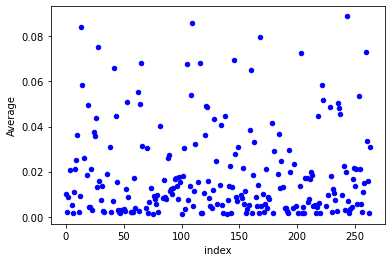

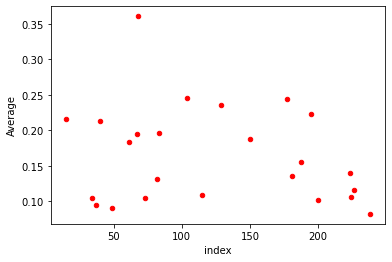

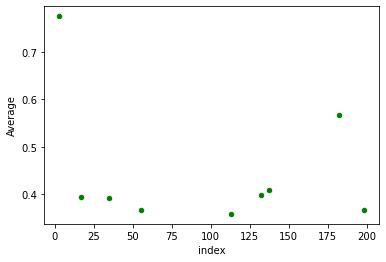

In [85]:
df_venue[df_venue['Group']==0].plot(x='index',y='Average',kind='scatter',color='blue')
df_venue[df_venue['Group']==1].plot(x='index',y='Average',kind='scatter',color='red')
df_venue[df_venue['Group']==2].plot(x='index',y='Average',kind='scatter',color='green')

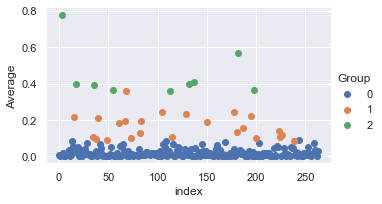

<Figure size 1080x1440 with 0 Axes>

In [86]:
seaborn.set(style='ticks')
seaborn.set(rc={'figure.figsize':(11.7,200)})

_groups= [0, 1, 2]

fg = seaborn.FacetGrid(data=df_venue, hue='Group', hue_order=_groups, aspect=1.61)
pyplot.figure(figsize=(15,20))
fg.map(pyplot.scatter, 'index', 'Average').add_legend()
pyplot.savefig("Cluster Graph.jpeg")

</br>

## Part 3 - Visualize PA!

In [87]:
df_map = df_county[['County','Economic Index']].copy()
df_map['County'] = df_map['County'].str.upper()

In [88]:
county_geo = r'PaCounty2020.geojson'

In [89]:
# open the json file - json.load() methods returns a python dictionary
with open(county_geo) as county_file:
    counties_json = json.load(county_file)
    
# we loop through the dictionary to obtain the name of the communities in the json file
county_name_json = []
for index in range(len(counties_json['features'])):
    county_name_json.append(counties_json['features'][index]['properties']['COUNTY_NAM'])
    
county_name_json[0]


'BUTLER'

In [90]:
# Obtain location coordinates of Pennsylvania
address = 'Pennsylvania, US'

geolocator = Nominatim(user_agent="pa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Pennsylvania, US are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Pennsylvania, US are 40.9699889, -77.7278831.


In [91]:
# create map of Pennsylvania using latitude and longitude values
map_pa = folium.Map(location=[latitude, longitude], zoom_start=8)

In [92]:
#folium.GeoJson(county_shapes).add_to(map_pa)

In [93]:
map_pa.choropleth(
   geo_data=county_geo,
    data=df_map,
    columns=['County', 'Economic Index'],
    key_on='feature.properties.COUNTY_NAM',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Economic Index',
    smooth_factor=0
)

In [94]:
# add markers to map
for lat, lng, county in zip(df_county['Latitude'], df_county['Longitude'], df_county['County']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pa)  
    

In [95]:
display(map_pa)

In [96]:
map_pa.save('map.html')

In [97]:
output = pd.merge(left=df_economic,right=df_county[['County','Economic Index']],on='County')

In [98]:
output

County Per Capita Income Median Household Income  \
0          Chester           $41,251                 $84,741   
1       Montgomery           $40,076                 $76,380   
2            Bucks           $35,687                 $74,828   
3         Delaware           $32,067                 $61,876   
4       Cumberland           $30,119                 $60,219   
5        Allegheny           $29,549                 $47,961   
6           Butler           $28,446                 $56,878   
7      Northampton           $28,362                 $58,762   
8          Dauphin           $27,727                 $52,371   
9             Pike           $27,564                 $56,843   
10          Lehigh           $27,301                 $53,541   
11            York           $27,196                 $57,494   
12         Montour           $26,124                 $45,255   
13      Washington           $26,045                 $49,687   
14       Lancaster           $25,854                 $54,765   
15    Westmoreland           $25,845                 $47,689   
16           Adams           $25,606                 $56,529   
17         Lebanon           $25,525                 $52,356   
18           Berks           $25,518                 $53,470   
19        Franklin           $25,307                 $51,035   
20          Monroe           $24,824                 $56,733   
21          Beaver           $24,168                 $46,190   
22      Lackawanna           $24,152                 $43,673   
23          Centre           $23,744                 $47,016   
24           Perry           $23,701                 $52,659   
25         Luzerne           $23,245                 $42,224   
26          Carbon           $22,956                 $47,744   
27         Wyoming           $22,899                 $47,403   
28           Blair           $22,880                 $42,363   
29             Elk           $22,729                 $43,745   
30            Erie           $22,644                 $43,595   
31           Wayne           $22,525                 $45,930   
32        Columbia           $22,403                 $42,788   
33     Susquehanna           $22,173                 $43,457   
34          Warren           $22,170                 $41,286   
35       Armstrong           $21,828                 $42,752   
36        Lycoming           $21,802                 $42,689   
37          Mercer           $21,765                 $42,573   
38          Fulton           $21,739                 $45,240   
39           Union           $21,612                 $45,474   
40        Lawrence           $21,467                 $42,570   
41      Schuylkill           $21,408                 $42,315   
42         Cameron           $21,375                 $40,733   
43         Cambria           $21,278                 $39,574   
44    Philadelphia           $21,117                 $36,251   
45          Snyder           $21,072                 $44,713   
46          McKean           $21,022                 $40,097   
47        Bradford           $20,979                 $40,543   
48         Juniata           $20,682                 $44,276   
49  Northumberland           $20,654                 $38,387   
50      Huntingdon           $20,616                 $41,700   
51          Potter           $20,594                 $39,196   
52         Indiana           $20,587                 $40,225   
53         Bedford           $20,545                 $40,249   
54         Venango           $20,522                 $39,812   
55        Crawford           $20,383                 $38,924   
56           Tioga           $20,358                 $40,338   
57       Jefferson           $20,305                 $38,406   
58         Clarion           $20,259                 $40,028   
59          Greene           $20,258                 $40,498   
60      Clearfield           $20,142                 $37,130   
61        Somerset           $19,903        